In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from collections import Counter
import re
from time import sleep

In [80]:
def text_cleaner(text_url):
    txtpg_response = requests.get(text_url)
    page_soup=BeautifulSoup(txtpg_response.text, 'html.parser')
    for script in page_soup(["style", "script"]):
        script.extract()
    text = page_soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    def chunk_space(chunk):
        chunk_out = chunk + ' '
        return chunk_out      
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8')
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') 
    except:                                                            
        return
    text = re.sub(b"[^a-zA-Z.+3]",b" ", text)
    text = text.lower().split()
    text = list(set(text))
    return text

In [81]:
def postings_for_location(keyword, location):
    base_url="http://www.monster.ca/jobs/search/"
    paramslist={'q': keyword, 'where': location}
    job_postings=[]
    headers = requests.utils.default_headers()
    headers.update(
        {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
        }
    )

    response = requests.get(base_url, params=paramslist, headers = headers)
    while (response):
        print("collecting information from:" + response.url)
        soup = BeautifulSoup(response.text, 'html.parser')
        nextpage_results= soup.select('link[rel=next]')
        if nextpage_results:
            response = requests.get(nextpage_results[0]['href'], headers=headers)
        else:
            response=""

        all_rows = soup.select('div[class="jobTitle"] a')
        for row in all_rows:
            link = row["href"]
            print(link[-40:])
            job_postings.append(text_cleaner(link))
        sleep(2)
    return job_postings

In [82]:
toronto_postings = postings_for_location("Software-Development", 'Toronto,-Ontario')

collecting information from:http://www.monster.ca/jobs/search/?where=Toronto%2C-Ontario&q=Software-Development
aspx?mescoid=1100011001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1100011001001&jobPosition=1
aspx?mescoid=1100011001001&jobPosition=1
aspx?mescoid=1100011001001&jobPosition=1
aspx?mescoid=1500129001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500129001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
shawa-on-ca-173554851.aspx?jobPosition=1
sauga-on-ca-178151579.aspx?j

In [83]:
mtl_postings = postings_for_location("Software-Development", 'Montreal,-QC')

collecting information from:http://www.monster.ca/jobs/search/?where=Montreal%2C-QC&q=Software-Development
aspx?mescoid=1500128001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500129001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1100011001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500129001001&jobPosition=1
aspx?mescoid=1500129001001&jobPosition=1
aspx?mescoid=1500129001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500128001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
aspx?mescoid=1500127001001&jobPosition=1
ttawa-on-ca-178825373.aspx?jobPo

In [84]:
techlist=["javascript","sql", 'java', 'c#', 'php', 'c++', 'c', 'node.js', 'angularjs', 'ruby', 'rails', 'python', 
          'delphi', 'typescript', 'bash', 'groovy', 'powershell', 'html', 'css', 'django','postgresql', 'jquery', 'ios', 'git', 
          'mysql', '.net', 'arrays', 'swift', 'objective-c', 'string', 'json', 'sql server', 'linux', 'regex', 'asp.net' 
         'react', 'spark', 'cassandra', 'raspberry pi', 'wordpress', 'mongodb', 'redis', 'vba', 'hadoop', 'clojure'
         'go', 'f#', 'sharepoint', 'rust', 'scala', 'count', 'cordova', 'perl', 'salesforce', 'matlab', 'dart', 'coffeescript',
         'haskell', 'windows phone', 'aws', 'gae', 'azure', 'lamp']

def build_dic(postings):
    techdic={}
    for tech in techlist:
        techdic[tech] = 0

    for jobtech in postings:
        for tech in techlist:
            if bytearray(tech, "ascii") in jobtech:
                techdic[tech] += 1
    return techdic

In [85]:
toronto_dic = build_dic(toronto_postings)

In [86]:
mtl_dic = build_dic(mtl_postings)

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def chart(dic, title_city):
    df=pd.DataFrame.from_dict(dic, orient='index', dtype=None)
    df.columns=['count']
    df.sort_values(by='count', ascending=False, inplace=True)
    tofig=df.plot.bar(figsize=(15,8))
    tofig.set_title('Key Skills in ' + title_city, fontsize=14, fontweight='bold')

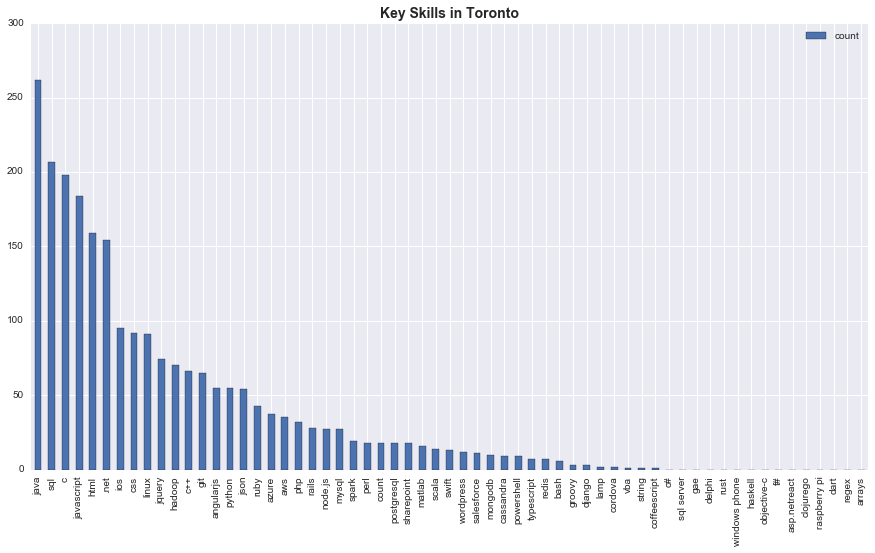

In [88]:
chart(toronto_dic, "Toronto")

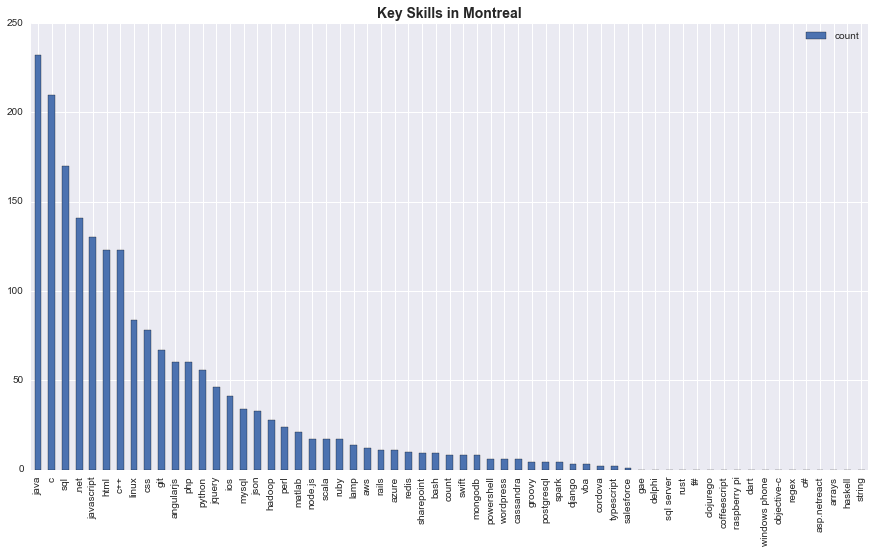

In [89]:
chart(mtl_dic, "Montreal")